# Nonlinear pendulum simulation

## The ODE

A simple pendulum swinging can be modeled with the ODE

$$\theta''(t) = -\dfrac{g}{L}\sin(\theta(t))$$

We'll solve this with both forward and backward Euler. For backward Euler, since $f(y,t)$ is nonlinear, we'll use the Newton-Raphson method for nonlinear equation solving at each time step.

Since it's a 2nd order ODE, we'll transform this into a system of two first order ODEs as follows

$$y_1 = \theta(t)$$

$$y_2 = \theta' = \omega(t)$$

$$\rightarrow \mathbf{y} = \left[\array{\theta \\ \theta'}\right]$$

Then

$$\mathbf{y}' = \left[\array{y_2 \\ -\dfrac{g}{L}\sin(y_1)}\right]$$

We'll also need the Jacobian $\mathbf{J} = \dfrac{\partial \mathbf{f}}{\partial \mathbf{y}}$ for the Newton-Raphson implementation. It is

$$\mathbf{J} = \dfrac{\partial \mathbf{f}}{\partial \mathbf{y}} = \left[\array{0 & 1 \\ -\dfrac{g}{L}\cos(y_1) & 0 }\right]$$

### Forward Euler

Forward Euler is a straightforward application of the algorithm $\mathbf{y}_{n+1} = \mathbf{y}_n + h\mathbf{f}(\mathbf{y}_n)$.

### Backward Euler

Backward Euler requires setup of the Newton-Raphson method.

The backward Euler update rule is:

$\mathbf{y}_{n+1} = \mathbf{y}_n + h\mathbf{f}(\mathbf{y}_{n+1})$

The nonlinear equation to solve for $\mathbf{y}_{n+1}$ at each time step is then

$\mathbf{F}(\mathbf{y}_{n+1}) = \mathbf{y}_{n+1} -\mathbf{y}_n -h\mathbf{f}(\mathbf{y}_{n+1}) = \mathbf{0}$

The Jacobian of this equation is

$D\mathbf{F}(\mathbf{y}_{n+1}) = \dfrac{\partial \mathbf{F}}{\partial \mathbf{y}_{n+1}} = I - h\dfrac{\partial \mathbf{f}}{\partial \mathbf{y}}(\mathbf{y}_{n+1})$

Newton-Raphson update scheme during each time step is

$\mathbf{y}_{n+1}^{k+1} = \mathbf{y}_{n+1}^k - [D\mathbf{F}(\mathbf{y}_{n+1}^k)]^{-1}\mathbf{F}(\mathbf{y}_{n+1}^k)$



## Code implementation

This code uses a convergence criteria of $|\mathbf{F}(\mathbf{y}_{n+1}^k)| \le \text{tol} $ with <code>tol = 1e-12</code>.

For ease of reading/writing the code, the following notation is used:
* <code>yn</code> refers to the solution $\mathbf{y}_n$ and is <b>fixed</b> during each time step
* <code>ynp1</code> refers to the solution $\mathbf{y}_{n+1}$ and is <b>iteratively updated</b> during each time step using the Newton Raphson method until convergence is achieved.
* The solution is updated via <code>y[:,n+1] = ynp1</code> only when $|\mathbf{F}(\mathbf{y}_{n+1})| \le \text{tol}$.

N =  5000 steps


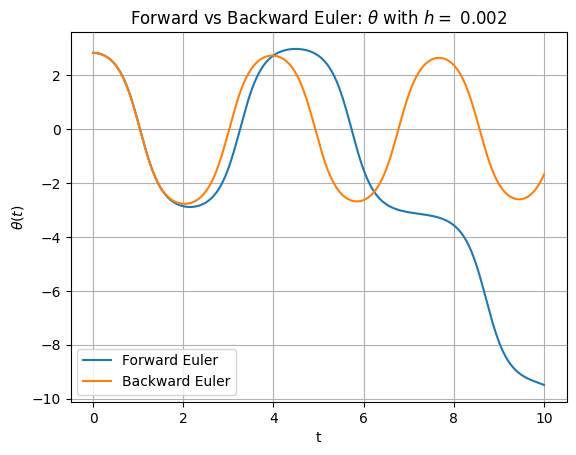

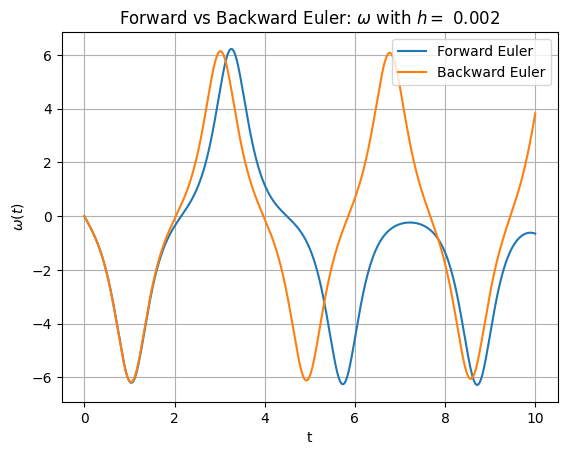

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81
L = 1

# f(y)
f  = lambda y: np.array([y[1], -g/L*np.sin(y[0])])

# Jacobian, df/dy
J = lambda y: np.array([[0, 1], [-g/L*np.cos(y[0]), 0]])

# Time stepping
h = 0.002
T = 10
N = round(T/h)
print('N = ', N, 'steps')
t = np.linspace(0, T, N+1)

# Preallocate solution arrays for forward and backward Euler
yfe = np.zeros((2,N+1))
ybe = np.zeros((2,N+1))

# Specify and set the initial condition
# Use radians for theta, rad/sec for omega
y0 = np.array([0.9*np.pi,0])
yfe[:,0] = y0
ybe[:,0] = y0

############# Forward Euler ##################
for n in range(N):
    yfe[:,n+1] = yfe[:,n] + h*f(yfe[:,n])
############# End Forward Euler ##############


############# Backward Euler #################
# Backward Euler equation to solve: F = 0 (2x1 vector)
F = lambda ynp1, yn: ynp1 - h*f(ynp1) - yn

# Jacobian of F
DF = lambda ynp1: np.eye(2) - h*J(ynp1)

# Newton-Raphson key parameters
maxiter = 10
tol = 1e-12
# Display iterative solution output
print_iters = False

# Backward Euler time step loop
for n in range(N):

    # Set yn to be the solution at time n
    yn = ybe[:,n]

    # Starting guess: yn is a good choice
    ynp1 = yn

    # 'itercount' will keep track of how many Newton iterations are done
    itercount = 0

    # Initialize 'converged' Boolean; Start Newton iteration loop
    converged = False
    while(not converged):
        # Newton update: ynp1 <-- ynp1 -  DF^{-1}*F
        ynp1 = ynp1 - np.linalg.solve(DF(ynp1), F(ynp1, yn))

        # Increment the iteration counter
        itercount += 1

        # Compute the error norm to see how close we are to convergence
        err = np.linalg.norm(F(ynp1, yn))

        # Print iteration info so we can monitor convergence
        if(print_iters):
            print(f"n: {n:4.0f} itercount: {itercount:2.0f}  |F(ynp1)| = {err:14.12f}")

        # If convergence: Accept ynp1 as the solution at time t(n+1)
        if(err < tol):
            ybe[:,n+1] = ynp1
            converged = True
        # Stop the algorithm if too many iterations are needed for convergence
        elif(itercount >= maxiter):
            print('Solution did not converge for n = ', n)
            break

    # Break out of the time step loop if convergence failed
    if(not converged):
        print('Simulation ended due to no convergence')
        break

############# End Backward Euler #############

# Plot theta vs time for each
# plt.plot(t,theta_linear,'--',label='Linear pendulum model')
plt.plot(t,yfe[0,:],label='Forward Euler')
plt.plot(t,ybe[0,:],label='Backward Euler')
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.title(r'Forward vs Backward Euler: $\theta$ with $h =$ '+str(h))
plt.legend()
plt.show()

# Plot omega vs time for each
# plt.plot(t,omega_linear,'--',label='Linear pendulum model')
plt.plot(t,yfe[1,:],label='Forward Euler')
plt.plot(t,ybe[1,:],label='Backward Euler')
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$\omega(t)$')
plt.title(r'Forward vs Backward Euler: $\omega$ with $h =$ '+str(h))
plt.legend()
plt.show()


## Comparison of Linear vs nonlinear pendulum motion

The linear model $\theta'' = -\sqrt{\dfrac{g}{L}}\theta$ is not applicable for large-amplitude swings.

The code below produces an animated plot that shows the motion of a linear pendulum vs a nonlinear pendulum, using the simulation data above. It is assumed the pendulum starts from initial angle $\theta_0$, at rest.

If you run the simulation from a small starting amplitude, e.g. $\theta_0 = 0.1$, the simulations will be very similar; they will deviate for large $\theta_0$, with the nonlinear model giving results closer to reality (excluding air resistance or other losses).

In [2]:
import matplotlib.animation as animation
from IPython.display import HTML

# Linear pendulum solution - use this to compare with the nonlinear model's motion
theta_linear = y0[0]*np.cos(np.sqrt(g/L)*t)
omega_linear = np.sin(np.sqrt(g/L)*t)*np.sqrt(g/L)

# x and y position of the mass; use backward Euler soln for the nonlinear motion
xlin =  L*np.sin(theta_linear)
ylin = -L*np.cos(theta_linear)
xnonlin =  L*np.sin(ybe[0,:])
ynonlin = -L*np.cos(ybe[0,:])

"""Animated plot of solution vs time"""
# Create the figure and axis
fig, ax = plt.subplots()
line1, = ax.plot([], [], lw=2, label='Linear model')
line2, = ax.plot([], [], lw=2, label='Nonlinear model')
point1, = ax.plot([], [], color='black', marker='.', markersize='20')
point2, = ax.plot([], [], color='black', marker='.', markersize='20')
leg = ax.legend(handles=[line1, line2], loc='upper right')

# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Pendulum motion')

# Initialization function to set up the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    point1.set_data([], [])
    point2.set_data([], [])
    ax.set_aspect('equal', 'box')
    ax.set(xlim=(-1.1*L, 1.1*L), ylim=(-1.1*L, 1.1*L))
    ax.grid()
    return line1, line2, point1, point2

# Animation function called sequentially to update the plot
def animate(j):
    line1.set_data([0, xlin[j]], [0, ylin[j]])
    line2.set_data([0,xnonlin[j]], [0,ynonlin[j]])
    point1.set_data([xlin[j]], [ylin[j]])
    point2.set_data([xnonlin[j]], [ynonlin[j]])
    ax.set_title(f'Time = {t[j]:.2f}')
    return line1, line2, point1, point2

# Call the animator
N_every = 20
ani = animation.FuncAnimation(fig, animate, frames=range(0, len(t), N_every), init_func=init, blit=True, interval=100)
plt.close(fig)  # Close the static plot before displaying the animation

# To display the animation in the Jupyter notebook
HTML(ani.to_jshtml())

# Alternatively, if you want to save it as an MP4 or GIF, use:
# ani.save('solution_animation.mp4', writer='ffmpeg')  # or 'solution_animation.gif', writer='imagemagick'

Output hidden; open in https://colab.research.google.com to view.

# Plotly animation



In [19]:
import plotly.graph_objects as go
import numpy as np

# Linear pendulum solution
theta_linear = y0[0]*np.cos(np.sqrt(g/L)*t)
omega_linear = np.sin(np.sqrt(g/L)*t)*np.sqrt(g/L)

# x and y position of the mass; use backward Euler soln for the nonlinear motion
xlin =  L*np.sin(theta_linear)
ylin = -L*np.cos(theta_linear)
xnonlin =  L*np.sin(ybe[0,:])
ynonlin = -L*np.cos(ybe[0,:])

# Frame skip
N_every = 10
frames_idx = range(0, len(t), N_every)

# Create base figure
fig = go.Figure()

# Add traces (initial positions, will update with frames)
fig.add_trace(go.Scatter(
    x=[0, xlin[0]], y=[0, ylin[0]],
    mode="lines+markers",
    line=dict(color="blue", width=2),
    marker=dict(size=[0,12], color="blue"),
    name="Linear model"
))

fig.add_trace(go.Scatter(
    x=[0, xnonlin[0]], y=[0, ynonlin[0]],
    mode="lines+markers",
    line=dict(color="red", width=2),
    marker=dict(size=[0,12], color="red"),
    name="Nonlinear model"
))

# Build frames for animation
frames = []
for j in frames_idx:
    frames.append(go.Frame(
        data=[
            go.Scatter(x=[0, xlin[j]], y=[0, ylin[j]]),        # linear line+point
            go.Scatter(x=[0, xnonlin[j]], y=[0, ynonlin[j]])   # nonlinear line+point
        ],
        name=str(j),
        layout=go.Layout(
            title_text=f"Pendulum motion (Time = {t[j]:.2f})"
        )
    ))

# Slider steps for each frame
slider_steps = []
for j in frames_idx:
    step = {
        "args": [[str(j)], {"frame": {"duration": 0, "redraw": True},
                            "mode": "immediate"}],
        "label": f"{t[j]:.2f}",
        "method": "animate"
    }
    slider_steps.append(step)

# Add play/pause and speed control buttons
fig.update_layout(
    title="Pendulum motion (Time = 0.00)",
    xaxis=dict(range=[-1.1*L, 1.1*L], zeroline=False),
    yaxis=dict(range=[-1.1*L, 1.1*L], scaleanchor="x", scaleratio=1, zeroline=False),
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 2, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}}],
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
            }
        ],
        "x": -0.0, "y": -0.2,  # position under plot
        "xanchor": "left", "yanchor": "top"
    }],
    sliders=[{
        "active": 0,
        "steps": slider_steps,
        "x": 0.1, "y": -0.1,
        "xanchor": "left", "yanchor": "top",
        "len": 0.9
    }],
    showlegend=True
)

# Attach frames
fig.update(frames=frames)

fig.show()
